In [1]:
%matplotlib inline
import datetime as datetime
from sklearn import datasets, linear_model
from sklearn import preprocessing as pre
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import requests
import seaborn as sb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib

In [29]:
conso = pd.read_csv('conso_train.csv', sep=';')
conso_test = pd.read_csv('sample_solution.csv', sep=';')
conso.date = pd.to_datetime(conso.date)
conso_test.date = pd.to_datetime(conso_test.date)
#On ajoute une seconde à la date car elle est sous la forme 22:59:59 jusqu'à fin décembre
conso.date = conso.date + datetime.timedelta(0,1); 
conso.index = conso.date
conso_test.index = conso_test.date
#Puis elle est sous la forme 22:00:00 à partir de début 2016 donc on re-rajoute une seconde à partir de là
conso2 = conso[2642:]
conso2.date = conso2.date - datetime.timedelta(0,1);
#et on fusionne le tout (using .loc[row_indexer,col_indexer] = value instead)
conso[2642:] = conso2;
conso = conso.drop(['date'], axis=1)
conso_test = conso_test.drop(['date'], axis=1)

meteo = pd.read_csv('meteo_train.csv', sep=';', usecols=['Date UTC', 'T¬∞ (C)', 'P (hPa)', 'HR (%)', 'P.ros√©e (¬∞C)', 'Visi (km)', 'Vt. moy. (km/h)','Vt. raf. (km/h)', 'Vt. dir (¬∞)','RR 3h (mm)','Neige (cm)','Nebul. (octats)'])
meteo_test = pd.read_csv('meteo_prev.csv', sep=';', usecols=['Date UTC', 'T¬∞ (C)', 'P (hPa)', 'HR (%)', 'P.ros√©e (¬∞C)', 'Visi (km)', 'Vt. moy. (km/h)','Vt. raf. (km/h)', 'Vt. dir (¬∞)','RR 3h (mm)','Neige (cm)','Nebul. (octats)'])
meteo.columns = ['date','temp','pression','hr','pros','visi','vmoy','vraf','vdir','rr','neige','nebul']
meteo_test.columns = ['date','temp','pression','hr','pros','visi','vmoy','vraf','vdir','rr','neige','nebul']
#Pour éviter les glitchs sur la date de météo
meteo.date = meteo.date.str.replace('h', ':')
meteo.date = pd.to_datetime(meteo.date, format='%d/%m/%y %H:%M')
meteo.date = meteo.date.dt.strftime('%Y-%m-%d %H:%M:%S')
meteo.index = meteo.date
meteo = meteo.drop(['date'], axis=1);

meteo_test.date = meteo_test.date.str.replace('h', ':')
meteo_test.date = pd.to_datetime(meteo_test.date, format='%d/%m/%y %H:%M')
meteo_test.date = meteo_test.date.dt.strftime('%Y-%m-%d %H:%M:%S')
meteo_test.index = meteo_test.date
meteo_test = meteo_test.drop(['date'], axis=1);



#Finalement on merge les deux tables pour en obtenir une seule contenant tous les données dont nous avons besoin
df = pd.merge(conso, meteo, right_index = True, left_index = True)
df = df.drop(['rr'], axis=1)
df = df.drop(['neige'], axis=1)
df = df.drop(['nebul'], axis=1)

conso_test = pd.merge(conso_test, meteo_test, right_index = True, left_index = True)
conso_test = conso_test.drop(['rr'], axis=1)
conso_test = conso_test.drop(['neige'], axis=1)
conso_test = conso_test.drop(['nebul'], axis=1)

#On ajoute le jour de la semaine et la semaine de l'année dans nos prédictions
df['weekday'] = df.index.weekday
df['week'] = df.index.week

#On instancie une nouvelle colonne jour
df['jour'] = 0

#On crée des tableau pour les jours, mois et heures
jour=[]
mois=['janvier','fevrier','mars','avril','mai','juin','juillet','aout','septembre','octobre','novembre','decembre']
heures=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

tab_mois = []
tab_heures = []
#On va créer des tableau de mois et heures de manières à les rajouter en tant que colonnes à notre dataframe
for i in range(len(mois)):
    tab = mois[i]
    tab = []
    tab_mois.append(tab)
    
for i in range(len(heures)):
    tab = heures[i]
    tab = []
    tab_heures.append(tab)
    
date = df.index
#On va réaliser le traitement sur la data permettant d'ajouter à la dataframe le jour, le mois et l'heure
for i in range(len(df)):
    dt = date[i]
    dt_month = dt.month
    dt_hour = dt.hour
    dt_day = dt.day
    for j in range(len(mois)):
        if dt_month == j+1:
            tab_mois[j].append(1)
        else:
            tab_mois[j].append(0)
            
    if dt_hour >= 7 and dt_hour <= 20:
        jour.append(1)
    else:
        jour.append(0)
        
    for k in range(len(heures)):
        if dt_hour == k:
            tab_heures[k].append(1)
        else:
            tab_heures[k].append(0)

#On finit par créer les colonnes dans la dataframe grâce au tableau traités précédemmenrt
for i in range(len(mois)):
    df[mois[i]] = tab_mois[i]
    
for i in range(len(heures)):
    df[heures[i]] = tab_heures[i]
          
df['jour'] = jour

df = df.dropna(axis = 0, how ='any')

conso_test['weekday'] = conso_test.index.weekday
conso_test['week'] = conso_test.index.week

#On instancie une nouvelle colonne jour
conso_test['jour'] = 0

#On crée des tableau pour les jours, mois et heures
jour=[]


tab_mois = []
tab_heures = []
#On va créer des tableau de mois et heures de manières à les rajouter en tant que colonnes à notre dataframe
for i in range(len(mois)):
    tab = mois[i]
    tab = []
    tab_mois.append(tab)
    
for i in range(len(heures)):
    tab = heures[i]
    tab = []
    tab_heures.append(tab)
    
date = conso_test.index
#On va réaliser le traitement sur la data permettant d'ajouter à la dataframe le jour, le mois et l'heure
for i in range(len(conso_test)):
    dt = date[i]
    dt_month = dt.month
    dt_hour = dt.hour
    dt_day = dt.day
    for j in range(len(mois)):
        if dt_month == j+1:
            tab_mois[j].append(1)
        else:
            tab_mois[j].append(0)
            
    if dt_hour >= 7 and dt_hour <= 20:
        jour.append(1)
    else:
        jour.append(0)
        
    for k in range(len(heures)):
        if dt_hour == k:
            tab_heures[k].append(1)
        else:
            tab_heures[k].append(0)

#On finit par créer les colonnes dans la dataframe grâce au tableau traités précédemmenrt
for i in range(len(mois)):
    conso_test[mois[i]] = tab_mois[i]
    
for i in range(len(heures)):
    conso_test[heures[i]] = tab_heures[i]
          
conso_test['jour'] = jour

#On divise la dataframe en deux dataframe, une d'entrainement et une de test
train_conso = df
test_conso = conso_test


D:\Programmes\Anaconda\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


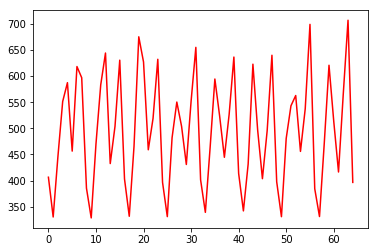

In [39]:
# On récupère les colonnes avec lesquels on souhaite faire la prédiction
names=['weekday','week','jour','temp','pression','hr','pros','visi','vmoy','vraf','vdir']+mois+heures
elts_train=[]
elts_test=[]

#On va créer une liste des valeurs d'entrainement
for i in range(len(train_conso)):
    conso_interm = []
    for j in range(len(names)):
        conso_interm.append(train_conso[names[j]][i])
    elts_train.append(conso_interm)
    
#On va créer une liste des valeurs de test    
for i in range(len(test_conso)):
    conso_interm = []
    for j in range(len(names)):
        conso_interm.append(test_conso[names[j]][i])
    elts_test.append(conso_interm)
    
#On choisit la méthode de regression que l'on souhaite utilisé  
reg_forest = RandomForestRegressor(max_depth = 100)

#On fit les données d'entrainement 
reg_forest.fit(elts_train, [[x] for x in train_conso.puissance])

#On prédit des valeurs de puissance grâce aux valeurs de test 
conso_y_pred_forest = reg_forest.predict(elts_test)

#On plot les valeurs prédites (En rouge) par rapport aux valeurs réelles (En bleu)
plt.plot(conso_y_pred_forest, color ='RED')
plt.show()

In [44]:
test_conso.puissance = conso_y_pred_forest
test_conso

,puissance,temp,pression,hr,pros,visi,vmoy,vraf,vdir,weekday,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2016-09-13 00:00:00,406.383333,18.3,1009.0,97,17.8,9.0,12.964,20.372,180,1,...,0,0,0,0,0,0,0,0,0,0
2016-09-13 03:00:00,330.250000,17.1,1007.4,98,16.8,0.4,3.704,11.112,50,1,...,0,0,0,0,0,0,0,0,0,0
2016-09-13 06:00:00,446.200000,17.6,1008.1,99,17.4,5.0,5.556,14.816,160,1,...,0,0,0,0,0,0,0,0,0,0
2016-09-13 09:00:00,551.483333,20.1,1007.2,87,17.9,45.0,11.112,18.520,40,1,...,0,0,0,0,0,0,0,0,0,0
2016-09-13 12:00:00,587.483333,23.3,1005.8,76,18.8,40.0,14.816,25.928,10,1,...,0,0,0,0,0,0,0,0,0,0
2016-09-13 15:00:00,456.416667,18.8,1005.1,93,17.6,5.0,14.816,29.632,10,1,...,0,1,0,0,0,0,0,0,0,0
2016-09-13 18:00:00,618.366667,17.2,1005.1,98,16.9,3.9,9.260,24.076,360,1,...,0,0,0,0,1,0,0,0,0,0
2016-09-13 21:00:00,596.966667,17.2,1005.1,98,16.9,3.0,12.964,25.928,60,1,...,0,0,0,0,0,0,0,1,0,0
2016-09-14 00:00:00,385.433333,17.5,1005.5,97,17.0,9.0,12.964,24.076,110,2,...,0,0,0,0,0,0,0,0,0,0
